In [ ]:
!pip install tensorflow scikit-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import cv2
import random
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
import time
import tqdm.gui as tqdm
import tqdm.notebook as tqdm
from tensorflow.keras.applications.efficientnet import preprocess_input



In [ ]:
# FUNCTION PREPROCESSING OF TRAINING DATA
def noisy_generator(generator, noise_factor=0.02):
    for x, y in generator:
        noisy_x = x + noise_factor * np.random.normal(0, 1, x.shape)
        noisy_x = np.clip(noisy_x, 0, 1)
        yield (noisy_x, y)

def get_data_generator(train_data_path, val_data_path, targetsize, classmode, batchsize, noise_factor=0.02):
    tr_dgen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
    v_dgen = ImageDataGenerator(preprocessing_function=preprocess_input)

    tr_gen = tr_dgen.flow_from_directory(train_data_path,
                                        target_size=targetsize,
                                        color_mode='rgb',
                                        batch_size=batchsize,
                                        class_mode=classmode,
                                        shuffle=True)

    v_gen = v_dgen.flow_from_directory(val_data_path,
                                      target_size=targetsize,
                                      color_mode='rgb',
                                      batch_size=batchsize,
                                      class_mode=classmode,
                                      shuffle=True)

    return noisy_generator(tr_gen, noise_factor), v_gen



def train_evaluate_the_model(tr_gen, \
                            v_gen, \
                            optimizer, \
                            epochs, \
                            dropout_value, \
                            TheModel):


    x = TheModel.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_value)(x)
    preds = Dense(4,activation='softmax')(x)
    model = Model(inputs = TheModel.input,outputs=preds)
    model.summary() # TO PRINT THE SUMMARY OF THE ARCHITECTURE

    for layer in TheModel.layers:
        layer.trainable = False


    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', #ADDING CATEGORICAL CROSSENTROPY AS LOSS
              metrics=['acc'])
    stsize_tr=train_generator.n//train_generator.batch_size

    r = model.fit_generator(generator=tr_gen,
                        validation_data=v_gen,
                        steps_per_epoch=stsize_tr,
                        epochs=epochs)

    scores = model.evaluate(v_gen)
    acc = scores[1]*100

    return acc, model      #RETURN ACCURACY AND MODEL

In [ ]:
tr_dgen=ImageDataGenerator(preprocessing_function=preprocess_input)
v_dgen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_dgen = ImageDataGenerator(preprocessing_function=preprocess_input)

targetsize_constant = (224,224)
dropout_value_initial = 0.5
optinitial = 'Adam'         #Optimizer as ADAM
batchsize_initial = 8
classmode_constant = 'categorical'
col_mode= 'rgb'


dataset_trainpath = '/content/drive/MyDrive/b7_data/Training'          #SETTING UP DATA PATH FOR TRAINING
dataset_validationpath = '/content/drive/MyDrive/b7_data/Validation'   #SETTING UP DATA PATH FOR VALIDATION
dataset_testpath = '/content/drive/MyDrive/b7_data/Testing'            #SETTING UP DATA PATH FOR TESTING


def add_noise(image, noise_factor=0.02):
    row, col, ch = image.shape
    mean = 0
    std = 1
    noisy = image + noise_factor * np.random.normal(mean, std, (row, col, ch))
    return np.clip(noisy, 0, 255)


train_generator_initial = tr_dgen.flow_from_directory(dataset_trainpath,
                                                 target_size=targetsize_constant,
                                                 color_mode=col_mode,
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant #SETTING COLOR MODE TO CATEGORICAL
                                                 ,shuffle=True)
val_generator_initial = v_dgen.flow_from_directory(dataset_validationpath,
                                                 target_size=targetsize_constant,
                                                 color_mode=col_mode,
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,#SETTING COLOR MODE TO CATEGORICAL
                                                 shuffle=True)
test_generator_initial = test_dgen.flow_from_directory(dataset_testpath,
                                                 target_size=targetsize_constant,
                                                 color_mode=col_mode,
                                                 batch_size=batchsize_initial,#SETTING BATCH SIZE TO8
                                                 class_mode=classmode_constant,#SETTING COLOR MODE TO CATEGORICAL
                                                 shuffle=True)


Found 2870 images belonging to 4 classes.
Found 2899 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
train_generator_initial.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
image_size = [224,224]
en7 = tf.keras.applications.efficientnet.EfficientNetB7(input_shape= image_size+[3],weights='imagenet',include_top=False)
en7_basemodel = en7
dropout_value_initial = 0.2
x = en7.output
#ADDING LAYERS TO THE ARCHITECTURE
x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
#x = Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(dropout_value_initial)(x)
predictions = Dense(4, activation="sigmoid")(x)
model = Model(inputs = en7.input, outputs = predictions)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_3[0][0]'

In [ ]:
for layer in en7.layers:
    layer.trainable = False

In [ ]:
loss='categorical_crossentropy'
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
epochs_initial = 10
step_size_train_initial=train_generator_initial.n//train_generator_initial.batch_size

tic = time.time()

r = model.fit_generator(generator=train_generator_initial,
                        validation_data=val_generator_initial,
                        steps_per_epoch=step_size_train_initial,
                        epochs=epochs_initial)

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

Epoch 1/10


<ipython-input-32-21756f1a6c5b>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator_initial,


358/358 [==============================] - 119s 268ms/step - loss: 3.9699 - acc: 0.6845 - val_loss: 0.6513 - val_acc: 0.8113
Epoch 2/10
358/358 [==============================] - 91s 254ms/step - loss: 0.7887 - acc: 0.7844 - val_loss: 0.3879 - val_acc: 0.8896
Epoch 3/10
358/358 [==============================] - 91s 253ms/step - loss: 0.4789 - acc: 0.8571 - val_loss: 0.4395 - val_acc: 0.8637
Epoch 4/10
358/358 [==============================] - 90s 253ms/step - loss: 0.3870 - acc: 0.8791 - val_loss: 0.2855 - val_acc: 0.9017
Epoch 5/10
358/358 [==============================] - 91s 253ms/step - loss: 0.3897 - acc: 0.8868 - val_loss: 0.2473 - val_acc: 0.9103
Epoch 6/10
358/358 [==============================] - 90s 252ms/step - loss: 0.3442 - acc: 0.8913 - val_loss: 0.4427 - val_acc: 0.8703
Epoch 7/10
358/358 [==============================] - 90s 252ms/step - loss: 0.3015 - acc: 0.9053 - val_loss: 0.2047 - val_acc: 0.9434
Epoch 8/10
358/358 [==============================] - 90s 252ms/s

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [ ]:
epochs_initial = 10
def train_evaluate_combined_model(train_generator, val_generator, optimizer, epochs, dropout_value, en7_base_model):
    x_efn = en7_base_model.output
    x_efn = GlobalAveragePooling2D()(x_efn)
    x_efn = Dense(1024, activation='relu')(x_efn)
    x_efn = Dense(1024, activation='relu')(x_efn)
    x_efn = Dense(512, activation='relu')(x_efn)
    x_efn = tf.keras.layers.Dropout(dropout_value)(x_efn)
    preds_efn = Dense(4, activation='softmax')(x_efn)
    en7_model = Model(inputs=en7_base_model.input, outputs=preds_efn)
    en7_model.summary()

    for layer in en7_base_model.layers:
        layer.trainable = False

    en7_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    epoch_initial=10

    step_size_train = train_generator.n // train_generator.batch_size
    hist= en7_model.fit_generator(generator=train_generator, validation_data=val_generator, steps_per_epoch=step_size_train, epochs=epoch_initial)
    feature_vectors = en7_model.predict(val_generator)
    isolation_forest = IsolationForest(contamination=0.05, random_state=42)
    isolation_forest.fit(feature_vectors)

    outliers = isolation_forest.predict(feature_vectors)
    print("Number of outliers:", np.sum(outliers == -1))
    combined_predictions = []
    for ef_prediction, if_prediction in zip(en7_model.predict(val_generator), outliers):
        if if_prediction == -1:

            combined_predictions.append(1)
        else:

            combined_predictions.append(np.argmax(ef_prediction))


    scores = en7_model.evaluate(val_generator)
    acc = scores[1] * 100

    return hist, en7_model


In [ ]:
train_generator_initial, val_generator_initial = get_data_generator(dataset_trainpath, dataset_validationpath, targetsize_constant, classmode_constant, batchsize_initial)

accuracy_combined, combined_model = train_evaluate_combined_model(train_generator_initial, val_generator_initial, optinitial, epochs_initial, dropout_value_initial, en7_basemodel)

print("Combined Model Accuracy:", accuracy_combined)


Found 2870 images belonging to 4 classes.
Found 2899 images belonging to 4 classes.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescali

<ipython-input-12-81addfeb58e8>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist= en7_model.fit_generator(generator=train_generator, validation_data=val_generator, steps_per_epoch=step_size_train, epochs=epoch_initial)


Epoch 1/10
358/358 [==============================] - 115s 246ms/step - loss: 0.6419 - acc: 0.7484 - val_loss: 0.3672 - val_acc: 0.8682
Epoch 2/10
358/358 [==============================] - 82s 229ms/step - loss: 0.4064 - acc: 0.8442 - val_loss: 0.2859 - val_acc: 0.8737
Epoch 3/10
358/358 [==============================] - 81s 227ms/step - loss: 0.3142 - acc: 0.8816 - val_loss: 0.2254 - val_acc: 0.9172
Epoch 4/10
358/358 [==============================] - 81s 228ms/step - loss: 0.2737 - acc: 0.8910 - val_loss: 0.2173 - val_acc: 0.9186
Epoch 5/10
358/358 [==============================] - 82s 230ms/step - loss: 0.2349 - acc: 0.9123 - val_loss: 0.1262 - val_acc: 0.9541
Epoch 6/10
358/358 [==============================] - 81s 228ms/step - loss: 0.2081 - acc: 0.9319 - val_loss: 0.1393 - val_acc: 0.9455
Epoch 7/10
358/358 [==============================] - 81s 228ms/step - loss: 0.1793 - acc: 0.9326 - val_loss: 0.1506 - val_acc: 0.9403
Epoch 8/10
358/358 [==============================] - 

Combined Model Accuracy: <keras.src.callbacks.History object at 0x7e754cbba530>


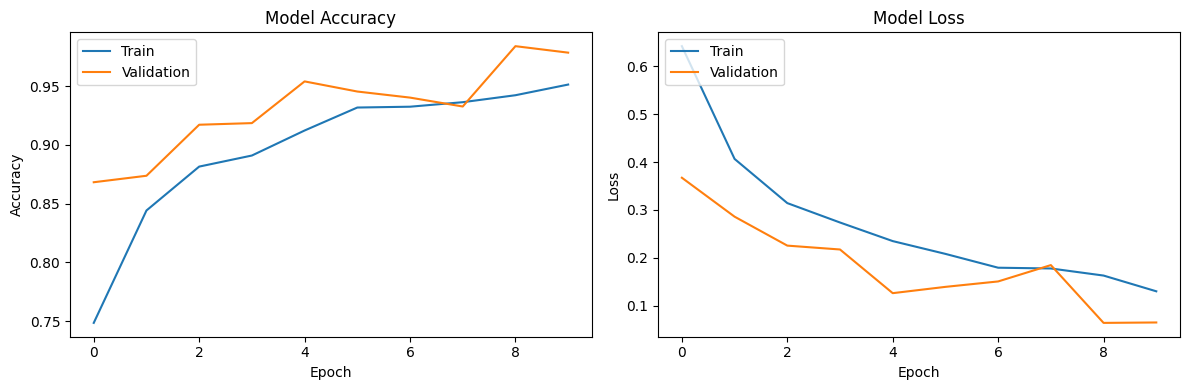

In [ ]:
print("Combined Model Accuracy:", accuracy_combined)

def plot_training_hist(hist):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plotting the graphs using the returned history
plot_training_hist(accuracy_combined)

In [ ]:


img_path = '/content/drive/MyDrive/b7_data/Testing/pituitary_tumor/image(19).jpg'
loadimage = image.load_img(img_path, target_size=(224,224))
image_array = image.img_to_array(loadimage)
image_array = np.expand_dims(image_array, axis=0)


preprocessed_image = preprocess_input(image_array)
prediction = combined_model.predict(preprocessed_image)
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

predicted_class = np.argmax(prediction)
class_name = class_labels[predicted_class]
confidence = prediction[0][predicted_class]

print(f"Predicted Class: {class_name}")
print(f"Confidence: {confidence * 100:.2f}%")


1/1 [==============================] - 7s 7s/step
Predicted Class: pituitary_tumor
Confidence: 95.75%
